In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Rectangle, Circle
from scipy.spatial.distance import euclidean
%matplotlib widget

In [2]:
class HexGridCustomized(object):
    def __init__(self, radius_n_tiles, inner_radius=8, radius_of_bounding_circle=60):
        """Note that hex size is distance btween centre and vertices.
        then assuming flat top tile: hex width = 2x size, hex height = sqrt(3) x size
        
        Note also that radius_n_tiles just needs to be set big enough... 
        TODO adapt code to just stop when it has done a full round not adding any new tiles. 
        """
        
        self.radius_of_bounding_circle = radius_of_bounding_circle

        # for scaling the cartesian coordinates to the desired ones
        original_distance = 2 * np.sqrt(3) /3 
        desired_distance = inner_radius * 2  # desired distance between adjacent hex mid points. 
        self.scaling_factor = desired_distance / original_distance
        
        self.hex_size = (inner_radius * 2) / np.sqrt(3)

        self.deltas = np.array([[1, 0, -1], [0, 1, -1], [-1, 1, 0], [-1, 0, 1], [0, -1, 1], [1, -1, 0]])
        self.radius = radius_n_tiles
        self.cube_coords = {0: (0, 0, 0)}
        self.cart_coords = {0: (0, 0)}
        self.edge_tiles = []
        
        tile = 1
        for r in range(radius_n_tiles):
            a = 0
            b = -r
            c = +r
            for j in range(6):
                num_of_hexes_in_edge = r
                for i in range(num_of_hexes_in_edge):
                    a = a + self.deltas[j][0]
                    b = b + self.deltas[j][1]
                    c = c + self.deltas[j][2]
                    
                    cube_coord = (a, b, c)
                    cart_coord = self.scale(self.to_cartesian(cube_coord))
                    
                    if not self.tile_within_circle(cart_coord):
                        continue
                        
                    self.cube_coords[tile] = cube_coord
                    self.cart_coords[tile] = cart_coord
                    
                    if r == self.radius - 1:
                        self.edge_tiles.append(tile)
                    tile += 1

        self.size = len(self.cube_coords)
        
    def tile_within_circle(self, tile_centre):
        vertex_coords = self.get_vertex_coords(*tile_centre)
        return np.all([np.linalg.norm(v) <= self.radius_of_bounding_circle for v in vertex_coords])
        
        
    def scale(self, coord):
        """We can just scale the cartesian coordinates only, keeping the unit steps in the cube coordinate system.
        """
        return tuple(self.scaling_factor * x for x in coord)
    
    def get_vertex_coords(self, centre_x, centre_y):
        angles = np.linspace(0, np.pi*2, 6, endpoint=False)
        coords = [(centre_x + self.hex_size * np.cos(theta), 
                   centre_y + self.hex_size * np.sin(theta)) for theta in angles]
        return coords
    
    def get_adjacency(self):
        adjacency_matrix = np.zeros((len(self.cube_coords), len(self.cube_coords)))
        for state, coord in self.cube_coords.items():
            for d in self.deltas:
                a = coord[0] + d[0]
                b = coord[1] + d[1]
                c = coord[2] + d[2]
                neighbour = self.get_state_id((a, b, c))
                if neighbour is not None:
                    adjacency_matrix[state, neighbour] = 1
        return adjacency_matrix

    def get_state_id(self, cube_coordinate):
        for state, loc in self.cube_coords.items():
            if loc == cube_coordinate:
                return state
        return None

    def is_state_location(self, coordinate):
        """Return true if cube coordinate exists.

        :param coordinate: Tuple cube coordinate
        :return:
        """
        for state, loc in self.cube_coords.items():
            if loc == coordinate:
                return True
        return False

    @staticmethod
    def to_cartesian(coordinate):
        xcoord = coordinate[0]
        ycoord = 2. * np.sin(np.radians(60)) * (coordinate[1] - coordinate[2]) / 3.
        return xcoord, ycoord

    def show_grid(self, ax=None, show_tile=None):
        if ax is None:
            fig, ax = plt.subplots()
        else:
            plt.sca(ax)
        ax.set_aspect('equal')
        for i, (x, y) in self.cart_coords.items():
            hex_patch = RegularPolygon((x, y), numVertices=6, radius = self.scaling_factor * 2./3.,
                                       orientation=np.radians(30), alpha=0.2, edgecolor='k')


            ax.add_patch(hex_patch)
            if show_tile == 'number':
                plt.text(x, y, i, ha='center', va='center', fontsize=6)
            elif show_tile == 'cube':
                a, b, c = self.cube_coords[i]
                s = '{},{},{}'.format(a, b, c)
                plt.text(x, y, s, ha='center', va='center', fontsize=6)
            elif show_tile == 'cartesian':
                s = '{:.0f}, {:.0f}'.format(x, y)
                plt.text(x, y, s, ha='center', va='center', fontsize=6)
            else:
                pass

        lower_bound = min(min(self.cart_coords.values())) * 1.5
        upper_bound = max(max(self.cart_coords.values())) * 1.5
        plt.xlim([lower_bound - 2, upper_bound + 2])
        plt.ylim([lower_bound - 2, upper_bound + 2])
        return ax

    def distance(self, state_a, state_b):
        return euclidean(self.cart_coords[state_a], self.cart_coords[state_b])

(-80.0, 80.0)

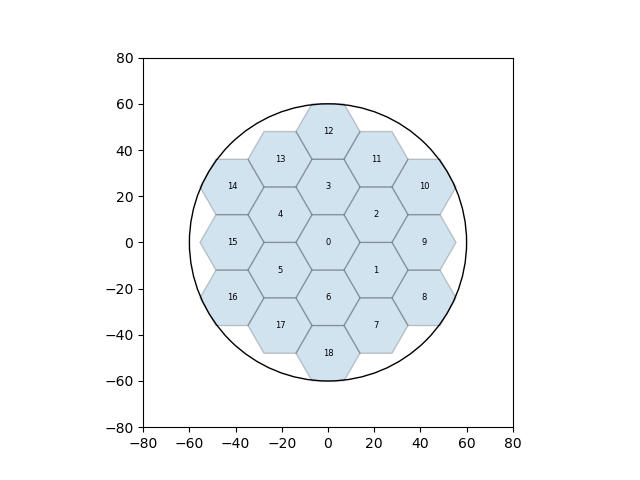

In [3]:
g= HexGridCustomized(20, inner_radius=12, radius_of_bounding_circle=70)

fig, ax = plt.subplots()
g.show_grid(ax, show_tile='number')

c = Circle((0,0), 60, fill=None)
ax.add_patch(c)


plt.xlim([-80, 80])
plt.ylim([-80, 80])


In [4]:
# # demo with smaller size. 

# g= HexGridCustomized(20, inner_radius=2, radius_of_bounding_circle=60)

# fig, ax = plt.subplots()
# g.show_grid(ax, show_tile='number')

# c = Circle((0,0), 60, fill=None)
# ax.add_patch(c)


# plt.xlim([-80, 80])
# plt.ylim([-80, 80])


In [5]:
# load table points
tps = pd.read_csv("C:\\Users\\Luke\\OneDrive\\Documents\\PhD\\AlloEye\\data\\sample_table_tps.csv")
t_info = pd.read_csv("C:\\Users\\Luke\\OneDrive\\Documents\\PhD\\AlloEye\\data\\sample_table_trialinfo.csv")
table_x = t_info.table_location_x.to_numpy()
table_z = t_info.table_location_z.to_numpy()
viewings = np.unique(tps.viewing_id)
t_info.style

,trial_id,study_id,ppt_id,block_id,practice,block_number,trial_number,configuration_number,move_type,table_rotates,anticlockwise_move,viewing_angle,object_shifted,selected_object,confidence_rating,co_preshift_x_raw,co_preshift_z_raw,co_preshift_x_rot_adj,co_preshift_z_rot_adj,co_postshift_x_raw,co_postshift_z_raw,co_postshift_x_rot_adj,co_postshift_z_rot_adj,co_shift_distance,obj1_name,obj1_preshift_x,obj1_preshift_z,obj1_postshift_x,obj1_postshift_z,obj2_name,obj2_preshift_x,obj2_preshift_z,obj2_postshift_x,obj2_postshift_z,obj3_name,obj3_preshift_x,obj3_preshift_z,obj3_postshift_x,obj3_postshift_z,obj4_name,obj4_preshift_x,obj4_preshift_z,obj4_postshift_x,obj4_postshift_z,obj5_name,obj5_preshift_x,obj5_preshift_z,obj5_postshift_x,obj5_postshift_z,table_location_x,table_location_z,hn_enc,hd_enc,p_matrix_enc,p_matrix_objects_enc,n_fix_total_enc,n_fix_obj1_enc,n_fix_obj2_enc,n_fix_obj3_enc,n_fix_obj4_enc,n_fix_table_enc,n_fix_other_enc,dwell_total_enc,dwell_obj1_enc,dwell_obj2_enc,dwell_obj3_enc,dwell_obj4_enc,dwell_table_enc,dwell_other_enc,t_first_array_enc,t_first_obj1_enc,t_first_obj2_enc,t_first_obj3_enc,t_first_obj4_enc,n_sacc_total_enc,n_sacc_obj1_enc,n_sacc_obj2_enc,n_sacc_obj3_enc,n_sacc_obj4_enc,n_sacc_table_enc,velocity_mean_total_enc,velocity_std_total_enc,pupil_diam_centre_enc,pupil_diam_spread_enc,hn_ret,hd_ret,p_matrix_ret,p_matrix_objects_ret,n_fix_total_ret,n_fix_obj1_ret,n_fix_obj2_ret,n_fix_obj3_ret,n_fix_obj4_ret,n_fix_table_ret,n_fix_other_ret,dwell_total_ret,dwell_obj1_ret,dwell_obj2_ret,dwell_obj3_ret,dwell_obj4_ret,dwell_table_ret,dwell_other_ret,t_first_array_ret,t_first_obj1_ret,t_first_obj2_ret,t_first_obj3_ret,t_first_obj4_ret,n_sacc_total_ret,n_sacc_obj1_ret,n_sacc_obj2_ret,n_sacc_obj3_ret,n_sacc_obj4_ret,n_sacc_table_ret,velocity_mean_total_ret,velocity_std_total_ret,pupil_diam_centre_ret,pupil_diam_spread_ret,hn_diff,hd_diff,n_fix_total_diff,n_fix_obj1_diff,n_fix_obj2_diff,n_fix_obj3_diff,n_fix_obj4_diff,n_fix_table_diff,n_fix_other_diff,dwell_total_diff,dwell_obj1_diff,dwell_obj2_diff,dwell_obj3_diff,dwell_obj4_diff,dwell_table_diff,dwell_other_diff,t_first_array_diff,t_first_obj1_diff,t_first_obj2_diff,t_first_obj3_diff,t_first_obj4_diff,n_sacc_total_diff,n_sacc_obj1_diff,n_sacc_obj2_diff,n_sacc_obj3_diff,n_sacc_obj4_diff,n_sacc_table_diff,velocity_mean_total_diff,velocity_std_total_diff,pupil_diam_centre_diff,pupil_diam_spread_diff,condition_id,d_kl,ea_td,n_fix_pp_enc,dwell_pp_enc,dispersion_mean_enc,drop_out_total_enc,n_fix_pp_ret,dwell_pp_ret,dispersion_mean_ret,drop_out_total_ret,n_fix_pp_diff,dwell_pp_diff,dispersion_mean_diff,drop_out_total_diff
0,alloeye_25r1_11,alloeye,alloeye_25,alloeye_25r1,False,1,11,23,Walk,False,True,135,Truck,Duck,3,0.415126,0.245987,0.415126,0.245987,-0.094292,0.067106,-0.094292,0.067106,0.539912,Truck,0.415126,0.245987,-0.094292,0.067106,Plane,0.046586,0.438666,0.046586,0.438666,Candle,0.239663,-0.070840,0.239663,-0.070840,Duck,0.391935,0.613691,0.391935,0.613691,Truck,-0.094292,0.067106,nan,nan,0.260397,0.280428,0.512377,0.495170,"[[0.0, 0.0, 0.0, 0.0, 0.09090909090909091], [0.0, 0.0, 0.0, 0.0, 0.18181818181818182], [0.0, 0.0, 0.0, 0.0, 0.09090909090909091], [0.0, 0.09090909090909091, 0.0, 0.0, 0.09090909090909091], [0.18181818181818182, 0.09090909090909091, 0.0, 0.18181818181818182, 0.0]]","[""Candle"", ""Duck"", ""OcclusionDome"", ""Plane"", ""Truck""]",19,9,3,3,3,0,1,5358,2150,401,2033,516,0,258,525,525,1033,1458,3458,20,9,2,2,4,2,0.006907,0.009056,2.808190,0.186537,0.631987,0.700238,"[[0.0, 0.0, 0.0, 0.125, 0.0, 0.0625], [0.0, 0.0, 0.0, 0.125, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0625, 0.0], [0.0, 0.0625, 0.0, 0.0, 0.0625, 0.125], [0.0, 0.0625, 0.0, 0.0, 0.0, 0.0625], [0.1875, 0.0, 0.0, 0.0625, 0.0, 0.0]]","[""Candle"", ""Duck"", ""OcclusionDome"", ""Plane"", ""Table"", ""Truck""]",23,6,7,5,2,2,1,6238,1358,2358,1199,499,549,275,400,1166,949,1316,750,24,4,8,7,2,2,0.009004,0.012751,2.970658,0.215977,0.119611,0.205068,4,-3,4,2,-1,2,0,880,-792,1957,-834,-17,549,17,

In [6]:
def adjust_loc(loc, table_loc, factor):
    return (loc - table_loc) * factor
x_enc = adjust_loc(tps.gaze_collision_x[tps.viewing_id ==viewings[0]].to_numpy(), table_x, 100)
z_enc = adjust_loc(tps.gaze_collision_z[tps.viewing_id ==viewings[0]].to_numpy(), table_z, 100)
x_ret = adjust_loc(tps.gaze_collision_x[tps.viewing_id ==viewings[1]].to_numpy(), table_x, 100)
z_ret = adjust_loc(tps.gaze_collision_z[tps.viewing_id ==viewings[1]].to_numpy(), table_z, 100)
x_both = (x_enc, x_ret)
z_both = (z_enc, z_ret)

def nearest_hex(g, point_2d):
    g_x = np.array([i[0] for i in g.cart_coords.values()])
    g_z = np.array([i[1] for i in g.cart_coords.values()])
    sqd_x = np.array((g_x - point_2d[0])**2)
    sqd_z = np.array((g_z - point_2d[1])**2)
    sqd_d = sqd_x + sqd_z
    return np.argmin(sqd_d)

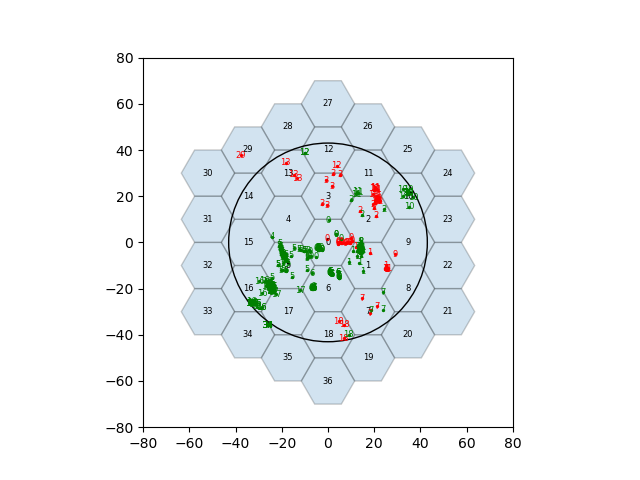

In [24]:
g= HexGridCustomized(30, inner_radius=10, radius_of_bounding_circle=80)

fig, ax = plt.subplots()
g.show_grid(ax, show_tile='number')

c = Circle((0,0), 55-12, fill=None)
ax.add_patch(c)
colours = ['red', 'green']
for v in range(len(viewings)):
    x = x_both[v]
    z = z_both[v]
    c = colours[v]
    for i in range(0, len(x)):
        hi = nearest_hex(g, (x[i], z[i]))
        plt.text(x[i], z[i], hi, ha='center', va='center', fontsize=6, c=c)
        ax.scatter(x[i], z[i], c=c, s=2)


plt.xlim([-80, 80])
plt.ylim([-80, 80])


plt.show()

In [8]:
# list(g.cart_coords.items())

In [9]:
def RotateAroundPoint(xz, rotateAbout, theta):
        xPrime = rotateAbout[0] + ((xz[0] - rotateAbout[0]) * np.cos(theta)) - ((xz[1] - rotateAbout[1]) * np.sin(theta));
        zPrime = rotateAbout[1] + ((xz[0] - rotateAbout[0]) * np.sin(theta)) + ((xz[1] - rotateAbout[1]) * np.cos(theta));
        return (xPrime, zPrime)
    

-1


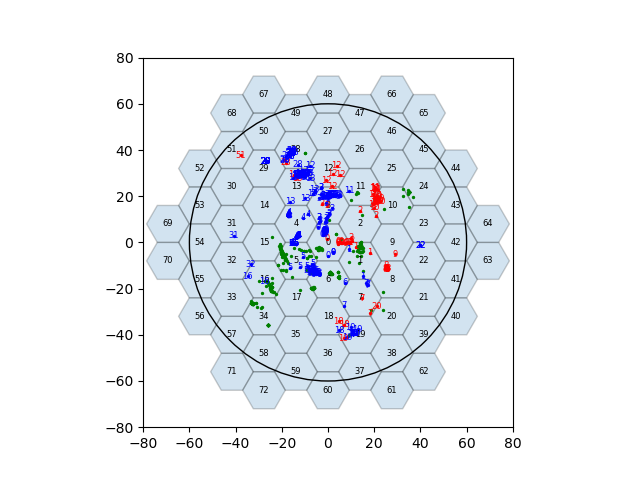

In [10]:
x_ret_adj = []
z_ret_adj = []
rot = 360
rot_dir = -1 if t_info.anticlockwise_move.reset_index(drop=True)[0] else 1
print(rot_dir)
for i in range(len(x_ret)):
    xz = (x_ret[i], z_ret[i])
    xz_adj = RotateAroundPoint(xz, (0, 0), rot*rot_dir)
    x_ret_adj.append(xz_adj[0])
    z_ret_adj.append(xz_adj[1])
x_both_norm = [x_enc, x_ret_adj] 
z_both_norm = [z_enc, z_ret_adj]

fig, ax = plt.subplots()
g.show_grid(ax, show_tile='number')

c = Circle((0,0), 60, fill=None)
ax.add_patch(c)
colours = ['red', 'blue']
for v in range(len(viewings)):
    x = x_both_norm[v]
    z = z_both_norm[v]
    c = colours[v]
    for i in range(0, len(x)):
        hi = nearest_hex(g, (x[i], z[i]))
        plt.text(x[i], z[i], hi, ha='center', va='center', fontsize=6, c=c)
        ax.scatter(x[i], z[i], c=c, s=2)
ax.scatter(x_ret, z_ret, c='green', s=2)
# ax.scatter()

plt.xlim([-80, 80])
plt.ylim([-80, 80])


plt.show()